# Modelo de Procesamiento de Datos de Movimiento

Autores: 

-Juan Sebastián Cely Botia

-Juan Carlos Ceron Lombana

-Juan Diego Díaz Guzmán
    
## Introducción

El modelo consiste en la captura y el procesamiento de datos de movimiento a partir de un dispositivo móvil para desarrollar un modelo de inteligencia artificial con capacidades de clasificación.

## Marco Teórico

- Acelerómetro: es un dispositivo que mide la aceleración de un objeto en un espacio tridimensional. Mide la aceleración propia, es decir, la aceleración experimentada relativa a la aceleración debida a la gravedad. Estos sensores se utilizan comúnmente en dispositivos móviles y wearables para detectar el movimiento y la orientación, convirtiéndolos en una fuente valiosa de datos para el reconocimiento de actividades humanas. (Mathie et al., 2004)

- HAR (Human Activity Recognition) o Reconocimiento de Actividades Humanas: se refiere al proceso de identificar y clasificar las acciones y movimientos realizados por personas a partir de datos recopilados por sensores, como acelerómetros, giroscopios, sensores de presión, entre otros. El objetivo principal de HAR es desarrollar sistemas y algoritmos capaces de reconocer e interpretar de manera precisa las actividades humanas en diferentes contextos y aplicaciones. (Lara & Labrador, 2013).

## Descripción del problema a solucionar

Se pretende desarrollar un modelo de inteligencia artificial mediante redes neuronales que sea capaz de clasificar correctamente datos de movimiento capturados con un acelerómetro de un teléfono móvil para los siguientes movimientos: corriendo, caminando, reposo, arriba, abajo, ola, izquierda y derecha. Se pretende entrenar el modelo con las series de coordenadas espaciales etiquetadas y comprobar su precisión mediante métricas establecidas. 

## Planteamiento de la solución

## Librerías

In [58]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from tensorflow import keras

### Importar datos del objeto JSON

In [5]:
# Cargar datos desde el archivo JSON para analizar un solo objeto
path = '../data/motion/reposo-jc (7).json' # Path par aGitHub
# path = '' # Path para Google Colab

with open(path, 'r') as file:
    datos_json = json.load(file)

# Extraer los valores de los sensores
valores_sensores = datos_json['payload']['values']

print("Valores de los sensores:")
print(valores_sensores)
np.array(valores_sensores).shape

Valores de los sensores:
[[0.20724806294096632, -8.825775507354736, -4.020163862609863], [0.30675705117490143, -8.838643756756186, -4.044404862158], [0.32785608116919174, -8.84313346939087, -4.071489852960408], [0.2657564208099618, -8.884283810424805, -4.059069639587402], [0.21847091975556684, -8.86767403640747, -3.9950241606563326], [0.19348134859614072, -8.862586357879637, -3.941155207824707], [0.2377740610427223, -8.83565158920288, -3.931428763580322], [0.30915136243291197, -8.835501367077232, -3.992779596599936], [0.32022450857851653, -8.835202676391601, -4.058920001983642], [0.2341827220198698, -8.888473663330078, -4.168155744989216], [0.22849660267485306, -8.871414976501464, -4.15004930267334], [0.2537852481123991, -8.863334545898438, -4.1509468360349535], [0.27832592472685497, -8.879046494293213, -4.032583783721924], [0.28820215270547195, -8.902539598083495, -3.8323686698913573], [0.2968809693267569, -8.87485664138794, -3.817854114587605], [0.2780266129867174, -8.871265338897704

(62, 3)

In [6]:
import os
"""
Función para crear una lista con los nombres de archivo 
de audio presentes en la ruta especificada. Además, se 
extrae la clase de cada audio.
"""
def listFiles(path):
    motionfiles = []
    targets = []
    for fileName in os.listdir(path):
        motionfiles.append(fileName)
        targets.append(fileName.split("-")[0])
    return motionfiles, targets

# Carga de los archivos de audio

path = "../data/motion" 
archivos, Y = listFiles(path)
print(len(archivos))
print(len(Y))
Y = np.array(Y)
Y.shape

112
112


(112,)

In [7]:
#Modelo ajustado
X = np.zeros((len(archivos),62, 3))
# Carga y generación de espectrogramas de cada archivo de movimiento
for i, archivo in enumerate(archivos):
    with open(os.path.join(path, archivo), 'r') as f:
        datos_json = json.load(f)
        mov_motion = datos_json['payload']['values']
        mov_motion = np.array(mov_motion)
        X[i,:,:] = mov_motion 
         
print(X.shape)
print(Y.shape)

(112, 62, 3)
(112,)


### Visualización de datos iniciales

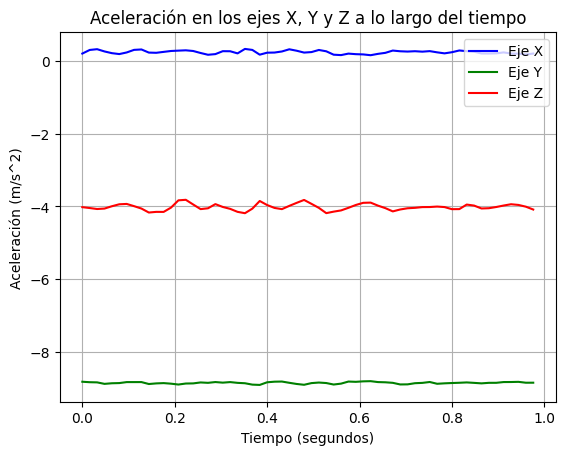

In [8]:
# Obtener los valores de la aceleración en el eje X, Y y Z
valores_x = [dato[0] for dato in valores_sensores]
valores_y = [dato[1] for dato in valores_sensores]
valores_z = [dato[2] for dato in valores_sensores]

# Crear una lista de tiempos para cada punto de datos
# Suponiendo que los datos se registraron a intervalos regulares de 16 ms
tiempos = [i * 0.016 for i in range(len(valores_x))]

# Trazar los valores de la aceleración en el eje X, Y y Z con respecto al tiempo
plt.plot(tiempos, valores_x, label='Eje X', color='blue')
plt.plot(tiempos, valores_y, label='Eje Y', color='green')
plt.plot(tiempos, valores_z, label='Eje Z', color='red')

plt.xlabel('Tiempo (segundos)')
plt.ylabel('Aceleración (m/s^2)')
plt.title('Aceleración en los ejes X, Y y Z a lo largo del tiempo')
plt.grid(True)
plt.legend()
plt.show()


### Análisis de patrones de movimiento

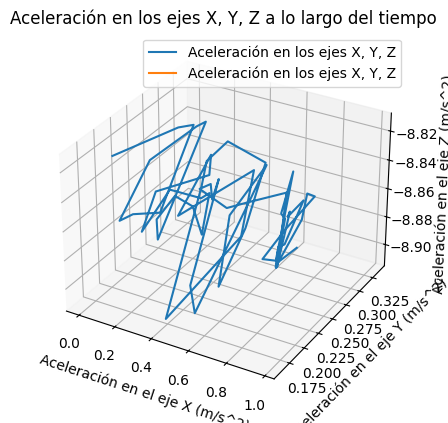

In [9]:

# Obtener los valores de aceleración en los ejes X, Y, Z
valores_x = [dato[0] for dato in valores_sensores]
valores_y = [dato[1] for dato in valores_sensores]
valores_z = [dato[2] for dato in valores_sensores]

# Crear una lista de tiempos para cada punto de datos
# intervalos regulares de 16 ms
tiempos = [i * 0.016 for i in range(len(valores_x))]

# Trazar la aceleración en los ejes X, Y, Z en una gráfica tridimensional
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(tiempos, valores_x, valores_y, valores_z, label='Aceleración en los ejes X, Y, Z')
ax.set_xlabel('Aceleración en el eje X (m/s^2)')
ax.set_ylabel('Aceleración en el eje Y (m/s^2)')
ax.set_zlabel('Aceleración en el eje Z (m/s^2)')
plt.title('Aceleración en los ejes X, Y, Z a lo largo del tiempo')
plt.grid(True)
plt.legend()
plt.show()

## Preparar los datos

In [11]:
valores_sensores = list(zip(valores_x, valores_y, valores_z))
datos = np.array(valores_sensores)  

## Escalar los datos

In [12]:
scaler = MinMaxScaler()
datos_escalados = scaler.fit_transform(datos)

## Visualizar los datos escalados


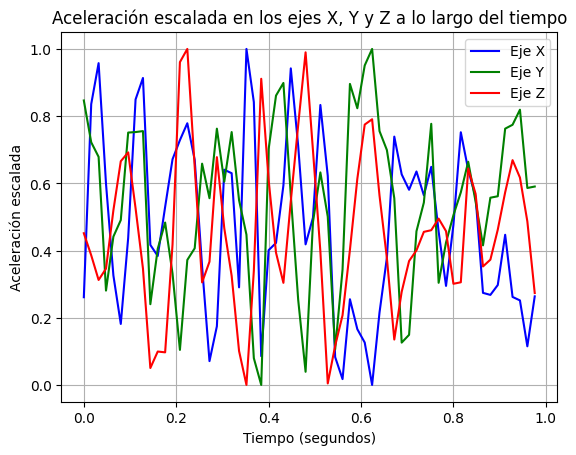

In [13]:
# Descomponer los datos escalados por eje para su visualización
datos_x_escalados = datos_escalados[:, 0]
datos_y_escalados = datos_escalados[:, 1]
datos_z_escalados = datos_escalados[:, 2]

# Crear los tiempos para cada punto de datos
tiempos = [i * 0.016 for i in range(len(datos_x_escalados))]

# Trazar los valores de la aceleración escalados en el eje X, Y y Z con respecto al tiempo
plt.plot(tiempos, datos_x_escalados, label='Eje X', color='blue')
plt.plot(tiempos, datos_y_escalados, label='Eje Y', color='green')
plt.plot(tiempos, datos_z_escalados, label='Eje Z', color='red')

plt.xlabel('Tiempo (segundos)')
plt.ylabel('Aceleración escalada')
plt.title('Aceleración escalada en los ejes X, Y y Z a lo largo del tiempo')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
#Definir los patametros de la ventana

tamaño_ventana = 10  # Por ejemplo, 10 mediciones consecutivas
paso_ventana = 1     # Cada ventana comienza 1 paso después de la anterior


In [15]:
#Creación de las ventanas

def crear_ventanas(datos, tamaño_ventana, paso_ventana):
    X = []
    n_muestras = len(datos) - tamaño_ventana + 1
    for inicio in range(0, n_muestras, paso_ventana):
        fin = inicio + tamaño_ventana
        ventana = datos[inicio:fin]
        X.append(ventana)
    return np.array(X)

In [16]:
# Aplicar la función a los Datos simulados
valores_x = np.random.rand(100)
valores_y = np.random.rand(100)
valores_z = np.random.rand(100)

# Combinar en un único array de (n_muestras, n_canales)
datos = np.column_stack((valores_x, valores_y, valores_z))

# Crear ventanas
X_train = crear_ventanas(datos, tamaño_ventana, paso_ventana)

In [17]:
#Verificar las dimensiones

print("Forma de la entrada de entrenamiento:", X_train.shape)


Forma de la entrada de entrenamiento: (91, 10, 3)


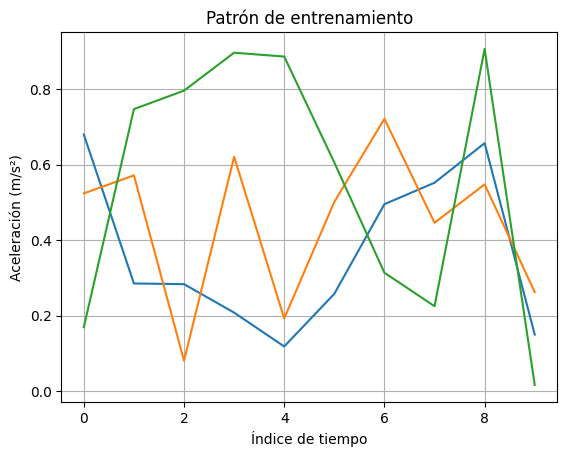

In [18]:
#Visualizar patrón de entrenamiento

# Visualizar la muestra número 10 del conjunto de entrenamiento
plt.plot(X_train[10,:,:])
plt.xlabel('Índice de tiempo')
plt.ylabel('Aceleración (m/s²)')
plt.title('Patrón de entrenamiento')
plt.grid(True)
plt.show()

## Modelo basado en MLP

In [19]:
#Visualización de dimensiones y categorias
encoder = LabelEncoder()
encoder.fit(Y)
Y_encoded = encoder.transform(Y)
Y_encoded = keras.utils.to_categorical(Y_encoded)
Y_encoded.shape

(112, 7)

In [20]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.2, random_state=42
)

# Definir el modelo MLP
model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation="relu",
    solver="adam",
    max_iter=1000,
    random_state=42,
    verbose=1,
)

# Entrenar el modelo
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# Calcular el error cuadrático medio

Iteration 1, loss = 17.80861777
Iteration 2, loss = 11.29321335
Iteration 3, loss = 6.75234593
Iteration 4, loss = 4.67684840
Iteration 5, loss = 3.78457786
Iteration 6, loss = 3.26573036
Iteration 7, loss = 3.08927626
Iteration 8, loss = 2.95342226
Iteration 9, loss = 2.61661187
Iteration 10, loss = 2.20616098
Iteration 11, loss = 1.84185298
Iteration 12, loss = 1.56692951
Iteration 13, loss = 1.34289604
Iteration 14, loss = 1.14052952
Iteration 15, loss = 0.95812589
Iteration 16, loss = 0.80351961
Iteration 17, loss = 0.69209297
Iteration 18, loss = 0.63954468
Iteration 19, loss = 0.63154129
Iteration 20, loss = 0.63318403
Iteration 21, loss = 0.61802013
Iteration 22, loss = 0.57541289
Iteration 23, loss = 0.51707730
Iteration 24, loss = 0.45610328
Iteration 25, loss = 0.40241941
Iteration 26, loss = 0.36732274
Iteration 27, loss = 0.35461121
Iteration 28, loss = 0.36060388
Iteration 29, loss = 0.37000161
Iteration 30, loss = 0.36727641
Iteration 31, loss = 0.34998449
Iteration 32, l

## Optimización de Hiperparametros

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}



In [22]:
#Utilizar RandomizedSearchCV
model = MLPClassifier(max_iter=200, random_state=42)

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, random_state=42)

# Realizar la búsqueda aleatoria
random_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)


c:\Users\juan.diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juan.diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juan.diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\juan.diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

Mejores hiperparámetros encontrados:
{'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.01, 'activation': 'relu'}


c:\Users\juan.diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Refinamiento del Modelo

In [47]:
refined_model = MLPClassifier(hidden_layer_sizes=(200, 100), activation='relu', solver='adam', alpha=0.001, learning_rate='adaptive', max_iter=1000, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
refined_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_refined = refined_model.predict(X_test.reshape(X_test.shape[0], -1))


# Calcular la precisión dentro de una cierta tolerancia 
tolerance = 0.1
accuracy = np.mean(np.abs(y_pred_refined - y_test) <= tolerance) * 100
print("Precisión dentro de una tolerancia de", tolerance, ":", accuracy, "%")

# Calcular perdida del modelo MLP
loss_refined = refined_model.loss_
print("Pérdida del modelo MLPRegressor:", loss_refined)

Precisión dentro de una tolerancia de 0.1 : 98.75776397515527 %
Pérdida del modelo MLPRegressor: 0.004288964954093497


## Definición del Modelo

In [105]:
# Número de clases de salida para la red neuronal
n_clases = len(np.unique(y_train))  # Asegúrate de haber definido y_train antes de este punto

# Definición del modelo secuencial de la red neuronal
modelo1 = keras.models.Sequential()
modelo1.add(keras.layers.Conv2D(8, 3, activation="relu", padding="same", input_shape=(124, 129, 1)))
modelo1.add(keras.layers.Conv2D(16, 3, activation="relu", padding="same"))
modelo1.add(keras.layers.Conv2D(32, 3, activation="relu", padding="same"))
modelo1.add(keras.layers.Conv2D(64, 3, activation="relu", padding="same"))
modelo1.add(keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
modelo1.add(keras.layers.Flatten())
modelo1.add(keras.layers.Dense(n_clases, activation='softmax'))


modelo1.summary()
keras.utils.plot_model(modelo1, to_file='motion_model2_plot.png', show_shapes=True, show_layer_names=True)

c:\Users\juan.diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 124, 129, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 124, 129, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 124, 129, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 124, 129, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 257920)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │       515,842 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 540,226 (2.06 MB)

 Trainable params: 540,226 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

AttributeError: module 'pydot' has no attribute 'InvocationException'

## Modelo de Convolución en 1D

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Número de clases de salida para la red neuronal
n_clases = len(np.unique(y_train))  # Asegúrate de haber definido y_train antes de este punto

# Definición del modelo secuencial de la red neuronal
modelo_conv1d = Sequential()
modelo_conv1d.add(Conv1D(8, kernel_size=3, activation='relu', input_shape=(124, 3)))
modelo_conv1d.add(MaxPooling1D(pool_size=2))
modelo_conv1d.add(Conv1D(16, kernel_size=3, activation='relu'))
modelo_conv1d.add(MaxPooling1D(pool_size=2))
modelo_conv1d.add(Conv1D(32, kernel_size=3, activation='relu'))
modelo_conv1d.add(MaxPooling1D(pool_size=2))
modelo_conv1d.add(Conv1D(64, kernel_size=3, activation='relu'))
modelo_conv1d.add(MaxPooling1D(pool_size=2))
modelo_conv1d.add(Flatten())
modelo_conv1d.add(Dense(n_clases, activation='softmax'))

modelo_conv1d.summary()


c:\Users\juan.diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 122, 8)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 61, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 59, 16)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 29, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 27, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 11, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │           642 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,898 (34.76 KB)

 Trainable params: 8,898 (34.76 KB)

 Non-trainable params: 0 (0.00 B)

## Visualización de la información capturada

In [129]:
model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 58, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 25, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,061 (1.06 MB)

 Trainable params: 92,353 (360.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 184,708 (721.52 KB)

## Compilación del Modelo

In [130]:
# Compilar el modelo
model.compile(loss='mean_absolute_error',  # Función de pérdida para regresión
              optimizer='adam',            # Optimizador Adam
              metrics=['mae'])             # Métrica de error absoluto medio


## Entrenamiento del Modelo

In [131]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.2858 - mae: 0.2858 - val_loss: 0.2490 - val_mae: 0.2490
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3090 - mae: 0.3090 - val_loss: 0.2072 - val_mae: 0.2072
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2757 - mae: 0.2757 - val_loss: 0.1910 - val_mae: 0.1910
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2784 - mae: 0.2784 - val_loss: 0.2030 - val_mae: 0.2030
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2610 - mae: 0.2610 - val_loss: 0.2142 - val_mae: 0.2142
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2604 - mae: 0.2604 - val_loss: 0.1900 - val_mae: 0.1900
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2243 - mae: 0.2243 - val_loss: 0.1610 - val_mae: 0.1610
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1987 - mae: 0.1987 - val_loss: 0.1591 - val_mae: 0.1591
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1907 - mae: 0.1907 - val_loss: 0

## Métricas del Modelo

In [134]:
# Compilar el modelo
modelo_conv1d.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
modelo_conv1d.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluar el modelo con los datos de prueba
pérdida, precisión = modelo_conv1d.evaluate(X_test, y_test, verbose=0)

# Imprimir las métricas
print("Pérdida en los datos de prueba:", pérdida)
print("Precisión en los datos de prueba:", precisión)


Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_22" is incompatible with the layer: expected axis -1 of input shape to have value 320, but received input with shape (None, 128)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 62, 3), dtype=float32)
  • training=True
  • mask=None

## Evaluación del Modelo

In [102]:
# Evaluate the model on the test data
loss, mae = model.evaluate(X_test, y_test)

# Print the loss and mean absolute error
print("Loss en el conjunto de prueba:", loss)
print("Error absoluto medio en el conjunto de prueba:", mae)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2210 - mae: 0.2210
Loss en el conjunto de prueba: 0.2210090458393097
Error absoluto medio en el conjunto de prueba: 0.2210090458393097


## Resultados

// Espacio para el análisis de los resultados obtenidos

## Referencias

_Mathie, M. J., Celler, B. G., Lovell, N. H., & Coster, A. C. (2004). Classification of basic daily movements using a triaxial accelerometer. Medical and Biological Engineering and Computing, 42(5), 679-687._ 

_Lara, O. D., & Labrador, M. A. (2013). A survey on human activity recognition using wearable sensors. IEEE Communications Surveys & Tutorials, 15(3), 1192-1209._